# Deep Q-Network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/06-deep-reinforcement-learning/02-deep-q-network.ipynb)

Deep Q-network (DQN) is one of the most popular deep RL algorithms and it started a series of research innovations that mark the history of RL. DQN claimed for the first time **superhuman level performance** on the **Atari benchmark** in which agents learned from raw pixel data from mere images [V. Mnih, et al. **"Playing Atari with Deep Reinforcement Learning"**, NIPS 2013](https://arxiv.org/abs/1312.5602)

1. [Value-based DRL challenges](#Value-based-DRL-challenges)
2. [Target networks](#Target-networks)
3. [Replay Memory](#Replay-Memory)
4. [Other exploration strategies](#Other-exploration-strategies)
5. [Nature DQN ](#Nature-DQN )
6. [DQN vs NFQ](#DQN-vs-NFQ)
7. [Double DQN](#Double-DQN)
8. [](#)


## Value-based DRL challenges

We need to understand the two most common problems that consistently show up in value-based deep reinforcement learning: the **violations of the IID assumption**, and the **stationarity of targets**.

In supervised learning, we obtain a full dataset in advance. We preprocess it, shuffle it, and then split it into sets for training. One crucial step in this process is the **shuffling of the data set**. By doing so, we allow our optimization method to avoid developing overfitting biases, reduce the variance of the training process, speed up convergence, and overall learn a more general representation of the underlying data-generating process. In reinforcement learning data is **gathered online** (they come from a sequence, a time series, a trajectory) and the experience sample generated at time step $t+1$ correlates with the experience sample generated at time step $t$. Moreover, samples are also not identically distributed, because they depend on the policy that generates the actions and the policy is changing through time (it improves).

XXX figura di IID XX

Also, in supervised learning, the targets used for training are fixed values on our dataset (fixed throughout the training process). In reinforcement learning **targets move with every training step** of the network. At every training update step, we optimize the approximate value function and therefore change the shape of the function, possibly the entire value function. Changing the value function means that the target values change as well, which, in turn, means the targets used are no longer valid. Because the targets come from the network, even before we use them, we can assume targets are invalid or biased at a minimum.

<img src="./images/stationary-problem.png" width="600">

## Target networks

A way to make target values more stationary is to have a separate network that we can fix for multiple steps and reserve it for calculating more stationary targets. The network with this purpose in DQN is called the **target network**.

<img src="./images/target-network-1.png" width="508"> <img src="./images/target-network-2.png" width="500">

This mitigates the issue of "chasing your own tail" by artificially creating **several small supervised learning problems** presented sequentially to the agent. Targets are fixed for as many steps as we fix our target network. It substantially reduces the chance of divergence.

The only difference with NFQ is the age of the neural network weights:

$\begin{align}
\nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{max}} Q(s',a;\theta_i) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right]
\end{align}$

$\begin{align}
\nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{max}} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right]
\end{align}$

Notice that in practice we don’t have two different networks. The target network is a **previous instance of the NN** that we freeze for a number of steps. The gradient update now has time to catch up to the target, which is much more stable when frozen. This adds stability to the updates. We use the same model architecture and frequently update the weights of the target network to match the weights of the **online network**, which is the network we optimize on every step. "Frequently" here means something different depending on the problem.

By using target networks, we prevent the training process from spiraling around because
we’re fixing the targets for multiple time steps, thus allowing the online network weights to move consistently toward the targets before an update changes the optimization problem,
and a new one is set. But we also **slow down learning** because you’re no longer training on up-to-date values. It’s essential to **balance stability and speed** by tuning this hyperparameter.

We can show this part in Python:

In [5]:
# this is the optimize method of the new algorithm
def optimize_model(self, experiences):
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)
        
    # notice: we now query the target network to get the estimate 
    # of the next state 
    q_sp = self.target_model(next_states).detach()
        
    # grab the maximum of those values
    # and make sure to treat terminal states appropriately
    max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
    max_a_q_sp *= (1 - is_terminals)
        
    # calculate the target 
    target_q_sa = rewards + self.gamma * max_a_q_sp
        
    # Query the current "online" estimate
    q_sa = self.model(states).gather(1, actions)

    # Use those values to create the errors 
    td_errors = q_sa - target_q_sa
    
    # calculate the loss, and optimize the online network
    value_loss = td_errors.pow(2).mul(0.5).mean()
    self.optimizer.zero_grad()
    value_loss.backward()
    self.optimizer.step()

In [6]:
# this is the interaction step method on the new algorithm
def interaction_step(self, state):
    
    # notice how we use the online model for selecting actions.
    action = self.train_strategy.select_action(self.online_model, state)
        
    new_state, reward, is_terminal, info = self.env.step(action)
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))
    self.experiences.append(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
    return new_state, is_terminal

In [8]:
# this is how the target network gets updated with the online network
def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
        target.data.copy_(online.data)

Another way to mitigate the non-stationarity issue, to some degree, is to use **larger networks**. With more powerful networks, subtle differences between states are more likely to be detected. Larger networks reduce the **aliasing** of state-action pairs (two states can look like the sameto the neural network, but still possibly require different actions). However, a more powerful neural network takes longer to train: it needs more data (interaction time) and more compute (processing time).

## Experience Replay

In NFQ, we use a mini-batch of $N$ samples, and train with it for $K$ iterations, alternating between calculating new targets and optimizingthe network. These $N$ samples are temporally correlated, because most of them belong to the same trajectory. **Experience replay** consists of a data structure (replay memory, called $D$) that holds experience samples $e_t=(S_t,A_t,R_{t+1},S_{t+1})$ for several steps (much more than $N$), such that $D={e_1, e_2, ..., e_M}$ (where $M$ is the size of the replay memory $N>>M$), allowing the **sampling of mini-batches from a broad set of past experiences**. In that way, the training process can use a more diverse mini-batch for performing updates, and the agent no longer has to fit the model to the same small mini-batch for multiple iterations. 

Adequately sampling a sufficiently large replay memory yields a slow-moving target, so the agent can now sample and train on every time step with a lower risk of divergence. Sampling uniformly at random from a substantial buffer chances are that our updates to the network are distributed all across, and therefore representative of the true value function. 

Moreover, the replay buffer gives the impression data are IID so that the optimization method is stable. Samples appear independent and identically distributed because of the sampling from multiple trajectories and even policies at once.

<img src="./images/dqn.png" width="600">

Unfortunately, the implementation becomes a challenge when working with high-dimensional observations, because poorly implemented replay buffers hit a hardware memory limit quickly in high-dimensional environments. In image-based environments, for instance, where each state representation is a stack of the four latest image frames, we probably don’t have enough memory to naively store the experience samples. 


The only difference with previous equation is that we’re now obtaining the experiences we use for training by sampling uniformly at random the replay buffer $D$, instead of using the online experiences as before:

$\begin{align}
\nabla_{\theta_i} L_i(\theta_i)=E_{s,a} \left[ ( r + \gamma \underset{a}{\text{max}} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right]
\end{align}$

$\begin{align}
\nabla_{\theta_i} L_i(\theta_i)=E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\text{max}} Q(s',a;\theta^-) - Q(s,a;\theta_i)) \nabla_{\theta_i} Q(s,a;\theta_i) \right]
\end{align}$

This is the full gradient update for DQN, more precisely the one referred to as **Nature DQN**, which is DQN with a target network and a replay buffer. We can implement the replay memory in Python:

In [55]:
import numpy as np

class ReplayMemory():
    def __init__(self, max_size=10000, batch_size=64):
        
        # initialize five arrays to hold states, actions, reward, next states, 
        # and done flags
        self.states      = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards     = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones       = np.empty(shape=(max_size), dtype=np.ndarray)

        # variables to do storage and sampling
        self.max_size = max_size
        self.batch_size = batch_size
        self.idx = 0
        self.size = 0
    
    def store(self, sample):
        
        # store a new sample 
        state, action, reward, next_state, done = sample
        self.states[self.idx] = state
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = next_state
        self.dones[self.idx] = done

        # idx points to the next index to modify, so we increase it, 
        # also make sure it loops back after reaching the maximum size 
        # (the end of the buffer)
        self.idx += 1
        self.idx = self.idx % self.max_size

        # size also increases with every new sample stored, 
        # but it doesn’t loop back to 0; it stops growing instead
        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        
        # determining the batch size
        if batch_size == None:
            batch_size = self.batch_size

        # sample batch_size ids from 0 to size.    
        idxs = np.random.choice(self.size, batch_size, replace=False)
        
        # extract the experiences from the buffer using the sampled ids
        experiences = np.vstack(self.states[idxs]), \
                      np.vstack(self.actions[idxs]), \
                      np.vstack(self.rewards[idxs]), \
                      np.vstack(self.next_states[idxs]), \
                      np.vstack(self.dones[idxs])
        return experiences

    # handy function to return the correct size of the memory
    def __len__(self):
        return self.size

## Other exploration strategies

Exploration is a vital component of reinforcement learning. In the NFQ, we use an epsilon-greedy exploration strategy (acting randomly with epsilon probability), however this is not the only possible strategies (see notebook about "Exploration vs Exploitation"). 

We implement them here in Python:

In [56]:
# Linearly decaying epsilon-greedy exploration strategy

class EGreedyLinearStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.t = 0
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.min_epsilon = min_epsilon
        self.decay_steps = decay_steps
        self.exploratory_action_taken = None
        
    def _epsilon_update(self):
        
        # start with a high epsilon value and decay its value in a linear fashion
        epsilon = 1 - self.t / self.decay_steps
        epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
        
        # We clip epsilon to be between the initial and the minimum value
        epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
        
        # hold the number of times epsilon has been updated
        self.t += 1
        return epsilon

    def select_action(self, model, state):
        
        # a variable used to calculate the percentage of exploratory actions 
        # taken per episode. Only used for logging information.
        self.exploratory_action_taken = False
        
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()

        # draw a random number from a uniform distribution and 
        # compare it to epsilon.    
        if np.random.rand() > self.epsilon:
            # if higher, use targmax of the q_values
            action = np.argmax(q_values)
        else: 
            # otherwise, a random action
            action = np.random.randint(len(q_values))
        
        # update epsilon
        self.epsilon = self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        
        return action

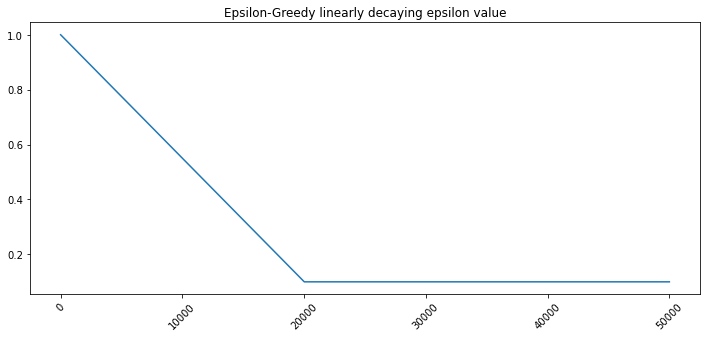

In [57]:
import matplotlib.pyplot as plt

s = EGreedyLinearStrategy()

plt.figure(figsize=(12,5))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy linearly decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In [58]:
# Exponentially decaying epsilon-greedy exploration strategy

class EGreedyExpStrategy():
    
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        
        # epsilon is decaying in an exponential curve
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action


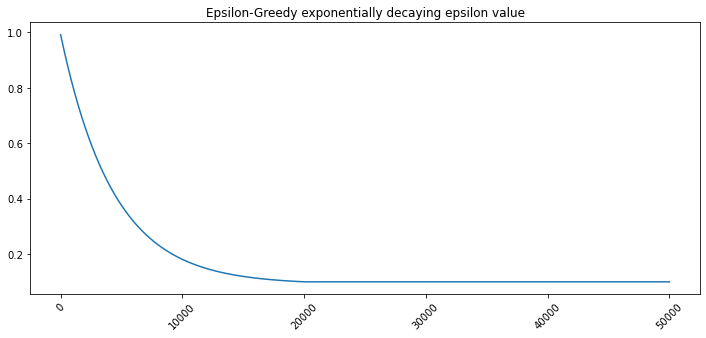

In [59]:
s = EGreedyExpStrategy()

plt.figure(figsize=(12,5))
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In DQN we will use the exponentially decaying epsilon-greedy strategy. It is simple and works well. But other, more advanced, strategies may be worth trying. Notice that even a small difference in hyperparameters, can make a significant difference in performance. 

In [60]:
# Softmax exploration strategy

class SoftMaxStrategy():
    
    def __init__(self, init_temp=1.0, min_temp=0.3, exploration_ratio=0.8, max_steps=25000):
        
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None
        
    def _update_temp(self):
        
        # we use a temperature parameter, which, the closer the value is to 0, 
        # the more pronounced the differences in the values will become, 
        # making action selection more greedy. 
        # The temperature is decayed linearly.
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        self.t += 1
        return temp

    def select_action(self, model, state):
        
        self.exploratory_action_taken = False
        temp = self._update_temp()

        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
            
            # accentuate differences
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()            
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            
        # use probabilities to select an action. 
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

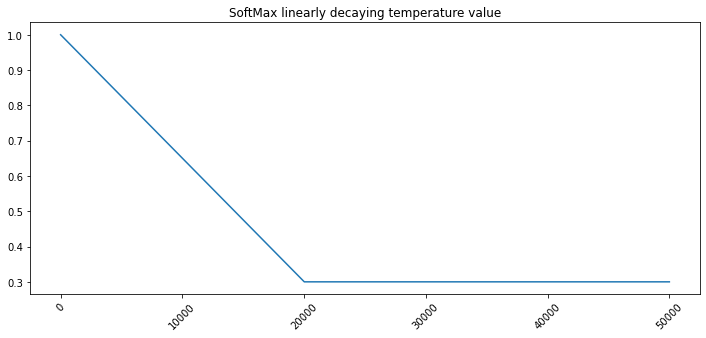

In [61]:
s = SoftMaxStrategy()

plt.figure(figsize=(12,5))
plt.plot([s._update_temp() for _ in range(50000)])
plt.title('SoftMax linearly decaying temperature value')
plt.xticks(rotation=45)
plt.show()

## Nature DQN 

We can now implement the full deep Q-network (DQN) algorithm, the main difference with NFQ are that we use an exponentially decaying epsilon-greedy strategy to improve policies, we use a replay buffer and a target network. So the algorithm has three main steps:
1. collect experience: (St , At , Rt+1, St+1, Dt+1), and insert it into the replay memory
2. randomly sample a mini-batch from the buffer, and calculate the off-policy TD targets for the whole batch
3. fit the action-value function Q(s,a; θ) using MSE and RMSprop

In [82]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim

class DQN():
    
    def __init__(self, env, online_model, target_model, optimizer, 
                 train_strategy, eval_strategy, replay_memory,
                 seed, n_warmup_batches, target_update_steps):
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env = env
        self.replay_memory = replay_memory
        self.online_model = online_model
        self.target_model = target_model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.n_warmup_batches = n_warmup_batches
        self.target_update_steps = target_update_steps

    def optimize_model(self, experiences):
        
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals))
        q_sa = self.online_model(states).gather(1, actions)

        td_error = q_sa - target_q_sa
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()

    def interaction_step(self, state):
        
        action = self.train_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = self.env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_memory.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        return new_state, is_terminal
    
    def update_network(self):
        
        for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
            target.data.copy_(online.data)

    def train(self, gamma, max_minutes, max_episodes, goal_mean_100_reward):
        
        training_start = time.time()
        last_debug_time = float('-inf')

        self.gamma = gamma
        
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.update_network()
                    
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = self.env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state)
                
                min_samples = self.replay_memory.batch_size * self.n_warmup_batches
                if len(self.replay_memory) > min_samples:
                    experiences = self.replay_memory.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.target_update_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            total_step = int(np.sum(self.episode_timestep))
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
                   
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes')
                if reached_max_episodes: print(u'--> reached_max_episodes')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward')
                break
                
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time
    
    def evaluate(self, n_episodes=1):
        
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.eval_strategy.select_action(online_model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
                
        return np.mean(rs), np.std(rs)


## DQN vs NFQ

We can show that DQN is more sample efficient than NFQ on the cart-pole environment

In [83]:
import gym
env = gym.make('CartPole-v1')

In [84]:
class GreedyStrategy():
    
    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
            return np.argmax(q_values)

In [85]:
import torch.nn as nn
import torch.nn.functional as F

class FCQ(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device='cpu', dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to('cpu')
        actions = torch.from_numpy(actions).long().to('cpu')
        new_states = torch.from_numpy(new_states).float().to('cpu')
        rewards = torch.from_numpy(rewards).float().to('cpu')
        is_terminals = torch.from_numpy(is_terminals).float().to('cpu')
        return states, actions, new_states, rewards, is_terminals

In [86]:
dqn_results = []
best_dqn_agent, best_dqn_eval_score = None, float('-inf')

gamma = 1.00
max_minutes = 20
max_episodes = 10000
goal_mean_100_reward = 475

target_update_steps = 10
n_warmup_batches = 5

nS, nA = env.observation_space.shape[0], env.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    online_model = FCQ(nS, nA, hidden_dims=(512,128))
    target_model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(online_model.parameters(), lr=0.0005)
    replay_memory = ReplayMemory(max_size=50000, batch_size=64)
    
    train_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
    eval_strategy = GreedyStrategy()
    
    
    agent = DQN(env, online_model, target_model, optimizer, 
                train_strategy, eval_strategy, replay_memory, seed, 
                n_warmup_batches, target_update_steps)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_mean_100_reward)

    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'
          .format(score, score_std, training_time))
    
    dqn_results.append(result)
    if score > best_dqn_eval_score:
        best_dqn_eval_score = score
        best_dqn_agent = agent
        
dqn_results = np.array(dqn_results)

Training started...
episode 0000, steps 000016, avg score 016.0±000.0, 
episode 0197, steps 021138, avg score 181.5±129.0, 
episode 0242, steps 040586, avg score 325.7±165.9, 
episode 0283, steps 057327, avg score 423.8±131.7, 
episode 0317, steps 073347, avg score 434.3±123.1, 
episode 0320, steps 074768, avg score 439.6±118.3, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 500.00±0.00 in 240.31s training time

Training started...
episode 0000, steps 000022, avg score 022.0±000.0, 
episode 0180, steps 019369, avg score 167.2±100.8, 
episode 0226, steps 035818, avg score 281.8±128.3, 
episode 0258, steps 050636, avg score 365.9±135.4, 
episode 0281, steps 061374, avg score 416.1±123.3, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 500.00±0.00 in 217.48s training time

Training started...
episode 0000, steps 000018, avg score 018.0±000.0, 
episode 0188, steps 016368, avg score 138.7±079.7, 
episode 0222, steps 031362, avg score 26

Now we reuse the NFQ code to make a comparison:

In [91]:
class EGreedyStrategy():
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach()
            q_values = q_values.data.numpy().squeeze()
        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

In [92]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim

class NFQ():
    def __init__(self, env, model, optimizer, train_strategy, eval_strategy,
                 seed, batch_size, epochs):
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env = env
        self.model = model
        self.optimizer = optimizer
        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch_size = batch_size
        self.epochs = epochs

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        q_sp = self.model(next_states).detach()
        max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
        max_a_q_sp *= (1 - is_terminals)
        target_q_sa = rewards + self.gamma * max_a_q_sp
        q_sa = self.model(states).gather(1, actions)
        td_errors = q_sa - target_q_sa
        value_loss = td_errors.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()

    def interaction_step(self, state):
        action = self.train_strategy.select_action(self.model, state)
        new_state, reward, is_terminal, info = self.env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.experiences.append(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.train_strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, gamma, max_minutes, max_episodes, goal_mean_100_reward):
        training_start = time.time()
        last_debug_time = float('-inf')
        self.gamma = gamma
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        self.experiences = []
        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            state, is_terminal = self.env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)
            for step in count():
                state, is_terminal = self.interaction_step(state)
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(self.experiences, dtype=object)
                    batches = [np.vstack(sars) for sars in experiences.T]
                    experiences = self.model.load(batches)
                    for _ in range(self.epochs):
                        self.optimize_model(experiences)
                    self.experiences.clear()
                if is_terminal:
                    break
            
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            total_step = int(np.sum(self.episode_timestep))
            evaluation_score, _ = self.evaluate()
            self.evaluation_scores.append(evaluation_score)
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print('--> reached_max_minutes')
                if reached_max_episodes: print('--> reached_max_episodes')
                if reached_goal_mean_reward: print('--> reached_goal_mean_reward')
                break
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        return result, final_eval_score, final_eval_std, training_time
    
    def evaluate(self, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.eval_strategy.select_action(self.model, s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

In [94]:
nfq_results = []
best_nfq_agent, best_nfq_eval_score = None, float('-inf')

gamma = 1.00
max_minutes = 20
max_episodes = 10000
goal_mean_100_reward = 475

batch_size = 1024
epochs = 40

nS, nA = env.observation_space.shape[0], env.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')
    
    model = FCQ(nS, nA, hidden_dims=(512,128))
    optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
    train_strategy = EGreedyStrategy(epsilon=0.5)
    eval_strategy = GreedyStrategy()
    
    agent = NFQ(env, model, optimizer, train_strategy, eval_strategy, seed, batch_size, epochs)
    result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_mean_100_reward)
    
    print('...training complete.')
    print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'
          .format(score, score_std, training_time))
    
    nfq_results.append(result)
    if score > best_nfq_eval_score:
        best_nfq_eval_score = score
        best_nfq_agent = agent
        
nfq_results = np.array(nfq_results)

Training started...
episode 0000, steps 000016, avg score 016.0±000.0, 
episode 0980, steps 061770, avg score 127.0±090.8, 
episode 1401, steps 118998, avg score 141.3±096.9, 
episode 1735, steps 178261, avg score 170.7±115.2, 
episode 2078, steps 232575, avg score 149.0±104.9, 
episode 2399, steps 288951, avg score 190.9±126.9, 
episode 2466, steps 300612, avg score 181.2±139.0, 
--> reached_goal_mean_reward
...training complete.
Final evaluation score 498.88±5.75 in 210.93s training time

Training started...
episode 0000, steps 000013, avg score 013.0±000.0, 
episode 1820, steps 062785, avg score 064.1±038.2, 
episode 2402, steps 123061, avg score 134.7±090.9, 
episode 2788, steps 181389, avg score 143.2±112.4, 
episode 3172, steps 238632, avg score 111.8±091.9, 
episode 3524, steps 298740, avg score 170.5±136.1, 
episode 3880, steps 355391, avg score 156.4±118.5, 
episode 4230, steps 415821, avg score 191.5±126.1, 
episode 4502, steps 466303, avg score 187.3±133.3, 
--> reached_goal

Then we can compare NFQ and DQN:

In [95]:
dqn_max_steps, dqn_max_train_reward, dqn_max_eval_score, dqn_max_time = np.max(dqn_results, axis=0).T
dqn_min_steps, dqn_min_train_reward, dqn_min_eval_score, dqn_min_time = np.min(dqn_results, axis=0).T
dqn_mean_steps, dqn_mean_train_reward, dqn_mean_eval_score, dqn_mean_time = np.mean(dqn_results, axis=0).T
dqn_episodes = np.arange(len(dqn_mean_steps))

nfq_max_steps, nfq_max_train_reward, nfq_max_eval_score, nfq_max_time = np.max(nfq_results, axis=0).T
nfq_min_steps, nfq_min_train_reward, nfq_min_eval_score, nfq_min_time = np.min(nfq_results, axis=0).T
nfq_mean_steps, nfq_mean_train_reward, nfq_mean_eval_score, nfq_mean_time = np.mean(nfq_results, axis=0).T
nfq_episodes = np.arange(len(nfq_mean_steps))


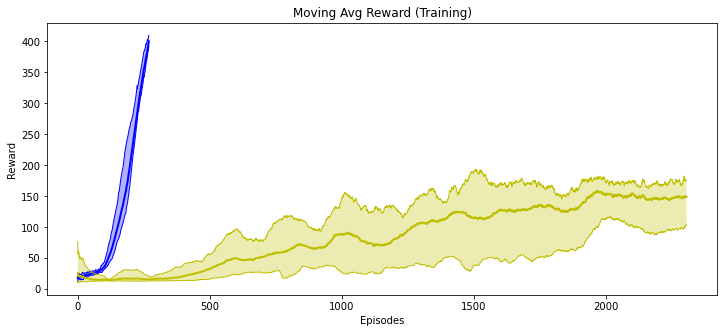

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(dqn_max_train_reward, 'b', linewidth=1)
plt.plot(dqn_min_train_reward, 'b', linewidth=1)
plt.plot(dqn_mean_train_reward, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_train_reward, dqn_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(nfq_max_train_reward, 'y', linewidth=1)
plt.plot(nfq_min_train_reward, 'y', linewidth=1)
plt.plot(nfq_mean_train_reward, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_train_reward, nfq_max_train_reward, facecolor='y', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

The most obvious conclusion we can draw is that DQN is more sample efficient than NFQ. But, if you pay attention to the curves, you notice how NFQ is also noisier than DQN.

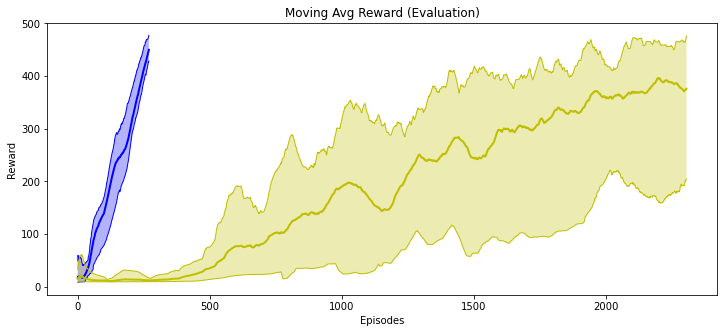

In [97]:
plt.figure(figsize=(12,5))

plt.plot(dqn_max_eval_score, 'b', linewidth=1)
plt.plot(dqn_min_eval_score, 'b', linewidth=1)
plt.plot(dqn_mean_eval_score, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_eval_score, dqn_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(nfq_max_eval_score, 'y', linewidth=1)
plt.plot(nfq_min_eval_score, 'y', linewidth=1)
plt.plot(nfq_mean_eval_score, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_eval_score, nfq_max_eval_score, facecolor='y', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Notice that they both pass the cart-pole environment, but DQN takes approximately 250 episodes while NFQ takes almost 2,500 episodes. That’s a tenfold reduction in samples.

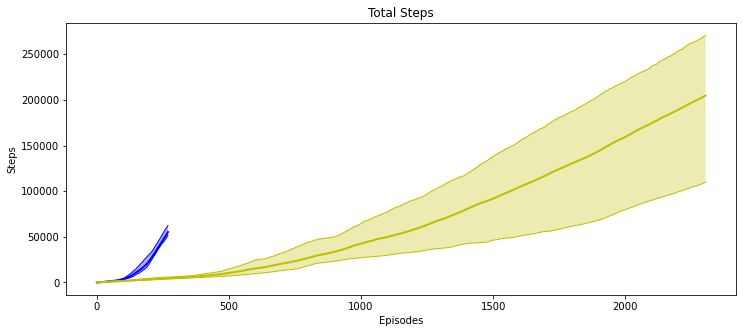

In [98]:
plt.figure(figsize=(12,5))

plt.plot(dqn_max_steps, 'b', linewidth=1)
plt.plot(dqn_min_steps, 'b', linewidth=1)
plt.plot(dqn_mean_steps, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_steps, dqn_max_steps, facecolor='b', alpha=0.3)

plt.plot(nfq_max_steps, 'y', linewidth=1)
plt.plot(nfq_min_steps, 'y', linewidth=1)
plt.plot(nfq_mean_steps, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_steps, nfq_max_steps, facecolor='y', alpha=0.3)

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')
plt.show()

Here you can see the same trend in sample efficiency, but with time steps instead of episodes: DQN takes about 50,000 experience tuples, while NFQ uses about 250,000.

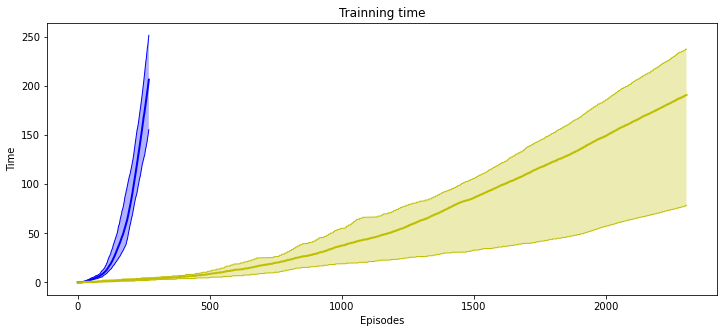

In [99]:
plt.figure(figsize=(12,5))

plt.plot(dqn_max_time, 'b', linewidth=1)
plt.plot(dqn_min_time, 'b', linewidth=1)
plt.plot(dqn_mean_time, 'b', linewidth=2)
plt.fill_between(dqn_episodes, dqn_min_time, dqn_max_time, facecolor='b', alpha=0.3)

plt.plot(nfq_max_time, 'y', linewidth=1)
plt.plot(nfq_min_time, 'y', linewidth=1)
plt.plot(nfq_mean_time, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_time, nfq_max_time, facecolor='y', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

However, DQN takes **more training time** than NFQ to pass the environment.

## Double DQN

